# LASSO最適化問題

## 0.設定

In [2]:
using Plots
using LinearAlgebra
using LaTeXStrings
using Random
using Plots.PlotMeasures; px

0.254mm

In [3]:
# 現在(2021/12/02) inv()でstack overflow が発生するので暫定対処
# 環境：Julia V1.6.4
BLAS.set_num_threads(1)

In [4]:
#シード固定とプログラムで使う型を決める
rng = MersenneTwister(20220105)
FT = Float32

Float32

## 1.問題設定
ランダム行列モデル

$\vec{x}_0$ : $N$成分ベクトル ($n$成分のみ非ゼロ；標準正規分布)  
$A$ : $(M\times N)$ ランダム行列（標準正規分布）  
$\vec{y} = A \vec{x}_0$ : インプット

In [6]:
function make_data(FT, N, n, M, σ)
    x = zeros(FT, N)
    x[1:n] = randn(rng, FT, n)
    shuffle!(rng, x)
    A = randn(rng, FT, (M,N))
    y = A * x + randn(rng, FT, M).*σ
    return (x, A, y)
end

make_data (generic function with 1 method)

In [13]:
xanswer, Amat, yinput = make_data(FT, 1000, 20, 100, 0.0)

(Float32[0.0, 0.0, 0.0, 0.0, -0.82367575, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.47889292 -0.43970445 … 1.0363846 1.2427783; -0.07613314 -0.09471851 … -0.90000165 -0.07315287; … ; 0.11095405 0.015285148 … 0.38829586 0.97854394; 0.9253884 0.62521356 … 0.1919082 0.46728405], [3.2416012287139893, 1.8238106966018677, 8.902076721191406, 4.068968772888184, -2.3916287422180176, 1.1242921352386475, 1.82449471950531, -2.969594955444336, -1.0583025217056274, 1.3651903867721558  …  0.14972460269927979, -0.45737653970718384, 2.401231288909912, -3.8675270080566406, -0.7675517797470093, -2.884434700012207, 3.206066131591797, 0.3098486065864563, 3.2778520584106445, 1.835594654083252])

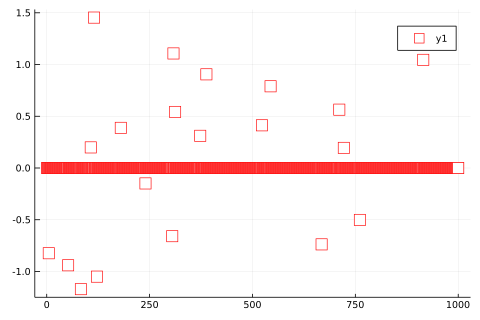

In [17]:
scatter(xanswer, shape=:square, mc=:white, msc=:red, dpi=20, ms=7)

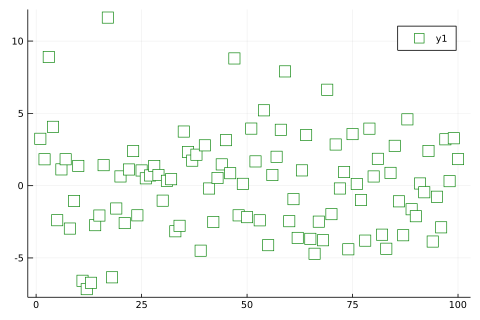

In [18]:
scatter(yinput, shape=:square, mc=:white, msc=:green, dpi=20, ms=7)

## 2.LASSO最適化の実装

In [20]:
function softThr(FT, y, λ) ::FT
    newλ = y > 0 ? λ : -λ
    abs(y) < λ ? 0 : y-newλ
end

function admm_bp(FT, A, y, max_iter=10000, tol=1e-5, μ=1.0) ::Vector{FT}
    M, N = size(A)
    x = zeros(FT, N)
    z = zeros(FT, N)
    u = zeros(FT, N)

    # A1 = Aᵀ(AAᵀ)⁻¹, A1y=A1*y
    A1 = A' * inv(A*A')
    A1y = A1 * y
    A2 = I - A1*A

    for t in 1:max_iter
        zold = z
        x = A1y + A2 * (z-u)
        z = softThr.(FT, x+u, 1/μ)
        u = u +x -z
        res1 = norm(z-x)
        res2 = norm(z-zold)
            if maximum([res1, res2]) < tol
                break
            end
    end    
    return z
end

function calc_acc(FT, x1, x2) ::FT
    # ⋅=\cdot... vector ⋅ vector = vector' * vector
    return (x1 ⋅ x2)/(norm(x1)*norm(x2))
end

calc_acc (generic function with 1 method)

In [33]:
function myplot(X, Y; figsize=(1000, 800), dpi=20)
    x, x_calc = X
    y, y_pred = Y
    # msc=markerstrokecolor
    plt1 = scatter(x, shape=:square, mc=:white, msc=:red, dpi=100, ms=7)
    scatter!(x_calc, shape=:+, mc=:blue, ms=5)
    plt2 = scatter(y, shape=:square, mc=:white, msc=:green, dpi=100, ms=7) 
    scatter!(y_pred, shape=:+, mc=:orange, ms=5)
    return plot(plt1, plt2, layout=(2, 1), size=figsize, dpi=dpi)
end

myplot (generic function with 1 method)

acc = 0.5993858180668202


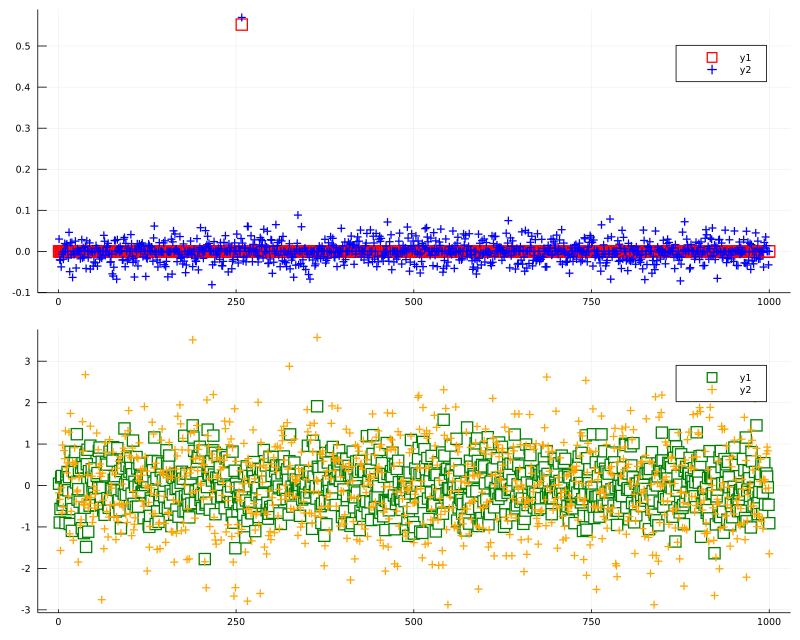

In [36]:
t = Float64
N = 1000
n = 1
M = 1000
x, A, y = make_data(Float32, N, n, M, 0.0)
x_calc = admm_bp(t, A, y)
y_pred = A * x_calc
acc = calc_acc(t, x, x_calc)
@show acc
myplot((x, x_calc), (y, y_pred), dpi=20)

## 3.サンプル　正解不正解の境界線

$\alpha > \rho$のもののみ計算

In [38]:
function sim2()
    t = Float64
    N = 1000
    div = 50
    n = [i for i in 0:Int(floor(N/div)):N]; n[1]=1
    M = [i for i in 0:Int(floor(N/div)):N]; M[1]=1
    acc = []
    for nn in n
        for MM in M
            if MM > nn
                x, A, y = make_data(t, N, nn, MM, 0.0)
                x_calc = admm_bp(t, A, y)
                y_pred = A * x_calc
                # myplot((x, x_calc), (y, y_pred))
                push!(acc, calc_acc(t, x, x_calc))
            else
                push!(acc, 0)
            end
            println("n=$(nn),  M = $(MM): ($(nn/N), $(MM/N)), $(acc[end])")
        end
    end
    return (n/N, M/N, acc)
end

sim2 (generic function with 1 method)

全部計算版

In [40]:
function sim_all()
    t = Float64
    N = 1000
    div = 10
    n = [i for i in 0:Int(floor(N/div)):N]; n[1]=1
    M = [i for i in 0:Int(floor(N/div)):N]; M[1]=1
    acc = []
    for nn in n
        for MM in M
            x, A, y = make_data(Float32, N, nn, MM, 0.0)
            x_calc = admm_bp(t, A, y)
            y_pred = A * x_calc
            # myplot((x, x_calc), (y, y_pred))
            push!(acc, calc_acc(t, x, x_calc))
            println("n=$(nn),  M = $(MM): ($(nn/N), $(MM/N)), $(acc)")
        end
    end
    return (n/N, M/N, acc)
end

sim_all (generic function with 1 method)

In [39]:
@time ρ, α, acc = sim2()

n=1,  M = 1: (0.001, 0.001), 0
n=1,  M = 20: (0.001, 0.02), 1.0
n=1,  M = 40: (0.001, 0.04), 1.0
n=1,  M = 60: (0.001, 0.06), 1.0
n=1,  M = 80: (0.001, 0.08), 1.0
n=1,  M = 100: (0.001, 0.1), 1.0
n=1,  M = 120: (0.001, 0.12), 1.0
n=1,  M = 140: (0.001, 0.14), 1.0
n=1,  M = 160: (0.001, 0.16), 1.0
n=1,  M = 180: (0.001, 0.18), 1.0
n=1,  M = 200: (0.001, 0.2), 1.0
n=1,  M = 220: (0.001, 0.22), 1.0
n=1,  M = 240: (0.001, 0.24), 1.0
n=1,  M = 260: (0.001, 0.26), 1.0
n=1,  M = 280: (0.001, 0.28), 1.0
n=1,  M = 300: (0.001, 0.3), 1.0
n=1,  M = 320: (0.001, 0.32), 1.0
n=1,  M = 340: (0.001, 0.34), 1.0
n=1,  M = 360: (0.001, 0.36), 1.0
n=1,  M = 380: (0.001, 0.38), 1.0
n=1,  M = 400: (0.001, 0.4), 1.0
n=1,  M = 420: (0.001, 0.42), 1.0
n=1,  M = 440: (0.001, 0.44), 1.0
n=1,  M = 460: (0.001, 0.46), 1.0
n=1,  M = 480: (0.001, 0.48), 1.0
n=1,  M = 500: (0.001, 0.5), 1.0
n=1,  M = 520: (0.001, 0.52), 1.0
n=1,  M = 540: (0.001, 0.54), 1.0
n=1,  M = 560: (0.001, 0.56), 1.0
n=1,  M = 580: (0.001, 0.5

([0.001, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18  …  0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0], [0.001, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18  …  0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0], Any[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

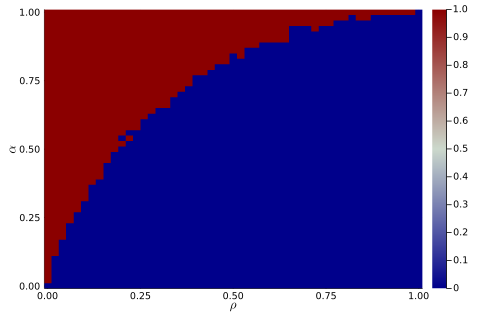

In [42]:
acc_reshaped = reshape(acc, size(α)[1], size(ρ)[1]) .> 1-1e-7
heatmap(ρ, α, acc_reshaped, color=:bluesreds, xlabel=L"\rho", ylabel=L"\alpha", dpi=20)